## Introduction/ Problem

In 2018 __New York City__ welcomed a record 65.2 million visitors, comprising 51.6 million domestic and 13.5 million international visitors, the ninth consecutive year of tourism growth. However, given the constant flowing of visitors, the reviews in the most visited travel guide platform, Tripadvisor, on accessibility to information while travelling in New York is notoriously bad. 

So why do tourists have difficulty accessing to information? 



## Data Collection

1. __New York Neighborhood__: has a total of 5 boroughs and 306 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and longitude coordinates of each neighborhood.

   Data source : https://cocl.us/new_york_dataset


2. __Fousquare API__: A dataset leveraging Foursquare API to tourist information centers/booths across the various neighborhoods of NYC.


Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install beautifulsoup4
!{sys.executable} -m pip install requests

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup

import json # library to handle JSON files

#install geopy
!pip install geopy

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import the library we use to open URLs
import urllib.request

print('Libraries imported.')

     |████████████████████████████████| 122kB 6.3MB/s eta 0:00:01
     |████████████████████████████████| 112kB 5.9MB/s eta 0:00:01
Libraries imported.


## 1. Download and Explore Dataset



In [29]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [30]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)


#### Transform Data into Pandas dataframe

In [31]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [32]:
#loop through the data and fill rows
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    

print(neighborhoods.shape)
neighborhoods.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### This shows that there are 306 neighborhood in NYC

#### Next, count number of neighborhood in each Borough

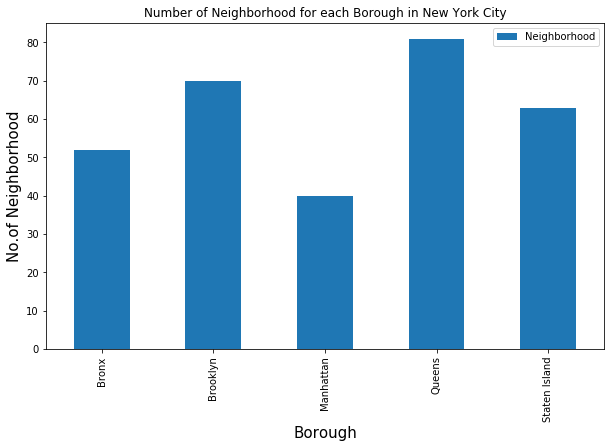

Borough
Bronx            52
Brooklyn         70
Manhattan        40
Queens           81
Staten Island    63
Name: Neighborhood, dtype: int64


In [63]:
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

plt.figure(figsize=(10,6))
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
neighborhoods.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

print(neighborhoods.groupby('Borough')['Neighborhood'].count())

## 2. Search for tourist information centers or booths using FourSquare API

#### Define Location

In [75]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [88]:
#use Foursquare
CLIENT_ID = 'H221G3EBRJAJZNQFWCRX5YDISWKB2OPRHNMJCWYXGAV2SELL' # your Foursquare ID
CLIENT_SECRET = 'PGSVG1CTDNL1BQL1XACAL3N3KVPCDVF43GYPT0B5EGFX0DCA' # your Foursquare Secret
VERSION = '20200630' # Foursquare API version

print("Credential checked")

Credential checked


#### Create a Map of New York with neighbourhood imposed on top

In [87]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### First, let's create the GET request URL

In [92]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#Get venues for all neighborhoods in our dataset
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                latitudes=neighborhoods['Latitude'],
                                longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [93]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### Let's see how many venues in each neighborhood

In [100]:
print(nyc_venues.shape)
nyc_venues.groupby('Neighborhood').count().head()

(10005, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,28,28,28,28,28,28
Annadale,9,9,9,9,9,9
Arden Heights,5,5,5,5,5,5
Arlington,7,7,7,7,7,7
Arrochar,21,21,21,21,21,21


#### Now let's see all the unique categories of venue

In [122]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
print("and they are:", nyc_venues['Venue Category'].unique())

There are 425 uniques categories.
and they are: ['Dessert Shop' 'Pharmacy' 'Ice Cream Shop' 'Donut Shop' 'Gas Station'
 'Sandwich Place' 'Food' 'Laundromat' 'Pizza Place' 'Discount Store'
 'Post Office' 'Bagel Shop' 'Grocery Store' 'Fast Food Restaurant'
 'Restaurant' 'Baseball Field' 'Deli / Bodega' 'Trail' 'Park'
 'Bus Station' 'Supermarket' 'Caribbean Restaurant' 'Diner'
 'Seafood Restaurant' 'Bowling Alley' 'Business Service'
 'Food & Drink Shop' 'Platform' 'Metro Station' 'Convenience Store'
 'Bus Stop' 'Cosmetics Shop' 'Plaza' 'River' 'Bank' 'Home Service' 'Gym'
 'Gourmet Shop' 'Latin American Restaurant' 'Pub' 'Burger Joint'
 'Beer Bar' 'Warehouse Store' 'Coffee Shop' 'Spanish Restaurant'
 'Mexican Restaurant' 'Bar' 'Wings Joint' 'Thrift / Vintage Store'
 'Bakery' 'Candy Store' 'Café' 'Rental Car Location' 'Fried Chicken Joint'
 'Breakfast Spot' 'Mattress Store' 'Pet Store' 'Supplement Shop'
 'Shipping Store' 'Sports Bar' 'Furniture / Home Store' 'Nail Salon'
 'Hotel' 'Shopping 

#### Is there 'Tourist Information Center' in the venue category?

In [163]:
"Tourist Information Center" in nyc_venues['Venue Category'].unique()

True

## 3. Analyze each neighborhood

In [126]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhoods'] = nyc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

print(nyc_onehot.shape)
nyc_onehot.head(10)

(10005, 426)


,Neighborhoods,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocer

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [129]:
nyc_grouped = nyc_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(nyc_grouped.shape)
nyc_grouped.head(10)

(302, 426)


,Neighborhoods,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocer

In [204]:
tic = nyc_grouped[["Neighborhoods","Tourist Information Center"]]

print(tic.shape)
tic.info

(302, 2)


<bound method DataFrame.info of                  Neighborhoods  Tourist Information Center
0                     Allerton                    0.000000
1                     Annadale                    0.000000
2                Arden Heights                    0.000000
3                    Arlington                    0.000000
4                     Arrochar                    0.000000
5                      Arverne                    0.000000
6                      Astoria                    0.000000
7              Astoria Heights                    0.000000
8                   Auburndale                    0.000000
9                   Bath Beach                    0.000000
10           Battery Park City                    0.000000
11                   Bay Ridge                    0.000000
12                 Bay Terrace                    0.000000
13                  Baychester                    0.000000
14                     Bayside                    0.000000
15                   Bay

In [173]:
#to find out how many info centre there are

nyc_venues['Venue Category'].value_counts()['Tourist Information Center']

2






## 4. Cluster the Neighborhood

#### Run K means to cluster and examine the cluster

In [179]:
# set number of clusters
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

In [180]:
# create a new dataframe that includes the cluster as well as tic for each neighborhood.
nyc_merged = tic.copy()

# add clustering labels
nyc_merged["Cluster Labels"] = kmeans.labels_
nyc_merged.head()

,Neighborhoods,Tourist Information Center,Cluster Labels
0,Allerton,0.0,0
1,Annadale,0.0,0
2,Arden Heights,0.0,0
3,Arlington,0.0,2
4,Arrochar,0.0,0


In [198]:
#how many clusters in each neighborhood

nyc_merged['Cluster Labels'].value_counts()

0    9915
3      53
2      35
4       1
1       1
Name: Cluster Labels, dtype: int64

## 5. Results and Discussion 

There are only __two OFFICIAL__ tourist information center/booth in New York: __in the neighborhood: St George (Borough: Staten Island) and Turtle Bay (Borough: Manhattan)__. While there are many tour companies (mainly in Manhattan) around that could offer some help when necessary, it is always under the impression that engaging a paid tour is subsequently needed. I believe this is the main reason albeit high ratings on various attraction spots, the general impression obtained from surveys is that it is hard to maneuver around by one own in New York. 

Tourism office of New York should consider setting up a lot more Tourist Information Center or Tourist Information Booth nearby attraction spots, it could be run by volunteers who are interested in the field of tourism, or by those who are interested to have language exchanges. 

## 6. Conclusion

In order to attract even more visitors to one of the best cities on Earth, the Tourism Office of New York should invest money and effort to set up Tourist Information Center/Booth like in Perth, Australia; or Bangkok, Thailand. 